# Random Walk
Calculation of end-to-end distance, radius of gyration, end monomer distribution

Radius of gyration: 
$R_g^2 = \frac{1}{N} \sum_i (\vec{r}_i - \vec{r}_{com})^2$

End to end position distribution 1D:
$P_{1D}(N,x) = \frac{1}{\sqrt{(2 \pi N b^2 )}} e^{-\frac{x^2}{2Nb^2}} = 1/(2\pi R2) \exp(- x^2 / R2)$

End to end position distribution radial:
$P_{rad}(N,R) 4\pi R^2 dR = 4 \pi \left( \frac{3}{2 \pi N b^2 } \right)^{3/2}  e^{-\frac{3 R^2}{2Nb^2}} R^2 dR = 4\pi (3/2 \pi R2) \exp(- 3 x^2 / 2 R2)$

Programming soft skills:
[docstrings](https://cito.github.io/byte_of_python/read/docstrings.html)

Load environments

In [1]:
%pylab notebook
# import pandas as pd
from scipy.optimize import curve_fit
import time

Populating the interactive namespace from numpy and matplotlib


In [2]:
# define class random walker (N, steps, full path, endpos; createRandomPath, calc Ree, calc Rg, plot path, performMCS)
class randomWalk:
    ''' definition of class radnom walk contianng the full path, the path length and steps along the principal lattice axis '''
    def __init__(self, N_):
        ''' initialize empty path and and start and end position in origin '''
        self.N          = N_
        self.fullPath   = np.zeros((2))
        self.start      = np.zeros((2))
        self.end        = np.zeros((2))
        self.currentPos = np.zeros((2))
        # self.steps = [(0,1), (1,1), (1,0), (1,-1), (0,-1), (-1,-1), (-1,0), (-1,1)]
        self.steps      = [(0,1),(0,-1),(-1,0),(1,0)]
    
    ''' create an initial random path ''' 
    def createRandomPath(self):   
        # always start at the start position defined in init
        self.currentPos = np.copy(self.start)
        self.fullPath   = np.zeros((2))
        
        # perform the walk
        sizeOfStep = len(self.steps)
        for i in range(self.N-1):
            newStep = self.steps[np.random.randint(sizeOfStep)]
            self.currentPos += newStep
            self.fullPath = np.vstack( (self.fullPath, self.currentPos) )
            
        # store last position in self.end
        self.end = self.currentPos
        
    def plotPath(self):
        ''' plot the current full path '''
        figure()
#         scatter(self.fullPath[:,0],self.fullPath[:,1], color="olive")
        plot(self.fullPath[:,0],self.fullPath[:,1],'o-',color="olive")
        plot(self.fullPath[0,0],self.fullPath[0,1], "r+", label="start")
        plot(self.fullPath[-1,0],self.fullPath[-1,1], "go", label="end")
        legend(loc="best")
        show()
        
    def showMovie(self,nMCS):
        ion()
        fig = plt.figure()
        ax = fig.add_subplot(111)
        xlim(-10,10)
        ylim(-10,10)
        line1, = ax.plot(self.fullPath[:,0],self.fullPath[:,1], "o-",color="olive")
        line2, = ax.plot(self.fullPath[0,0],self.fullPath[0,1], "ro", label="start")
        line3, = ax.plot(self.fullPath[-1,0],self.fullPath[-1,1], "go", label="end")
        ax.legend(loc="best")
        for i in range(0,nMCS):
            self.performMCS(1)
            line1.set_ydata(self.fullPath[:,1])
            line1.set_xdata(self.fullPath[:,0])
            line2.set_xdata(self.fullPath[0,0])
            line2.set_ydata(self.fullPath[0,1])
            line3.set_xdata(self.fullPath[-1,0])
            line3.set_ydata(self.fullPath[-1,1])
            fig.canvas.draw()
            fig.canvas.flush_events()
            time.sleep(0.1)
            
    def getEndToEndDistanceVector(self):
        ''' return the end to end vector '''
        return (self.end - self.start)
    
    def getEndToEndDistance(self):
        ''' return the norm of the end to end vector '''
        return np.linalg.norm(self.getEndToEndDistanceVector())
    
    def getRadiusOfGyrationSquared(self):
        ''' calculate the radius of gyration '''
        if self.fullPath.size == 2:
            raise NameError("Rg cannot be calculated from a single point")
            
        #centerOfMass = ( np.sum(self.fullPath[:,0]) / self.fullPath.shape[0] , np.sum(self.fullPath[:,1]) / self.fullPath.shape[0] )
        centerOfMass = self.fullPath.sum(axis=0) / self.fullPath.shape[0]
        
        #rgVector = np.sum( np.square( self.fullPath - centerOfMass ) / self.fullPath.shape[0], axis = 0 )
        #return np.sum(rgVector)
        return  np.sum( np.square( self.fullPath - centerOfMass ) / self.fullPath.shape[0] )
    
    
    def performMCS(self,t):
        ''' perform importance sampling t-times '''
        sizeOfStep = len(self.steps)
        for i in range(t):
            for n in range(self.N):
                #draw a random index
                randomIdx = random.randint(0,self.N)
                #start monomer 
                if (randomIdx == 0):
                    #direction for moving the monomer
                    newStep = self.steps[random.randint(sizeOfStep)]
                    # calculate difference to neigbor
                    diff = self.fullPath[1]-self.fullPath[0]
                    while ( newStep[0] == -diff[0] and newStep[1] == -diff[1] ):
                        newStep = self.steps[random.randint(sizeOfStep)]
                    # update position
                    self.fullPath[0]+=(newStep+diff)
                    #update start position 
                    self.start = 1*self.fullPath[0]
                #end monomer
                elif (randomIdx == self.N-1):
                    #direction for moving the monomer
                    newStep = self.steps[random.randint(sizeOfStep)]
                    diff = self.fullPath[-2]-self.fullPath[-1]
                    while ( newStep[0] == diff[0] and newStep[1] == diff[1] ):
                        newStep = self.steps[random.randint(sizeOfStep)]
                    # update position
                    self.fullPath[-1]+=(newStep+diff)
                    # update end
                    self.end = 1*self.fullPath[-1]
                else:
                    diff1 = self.fullPath[randomIdx+1]-self.fullPath[randomIdx]
                    diff2 = self.fullPath[randomIdx-1]-self.fullPath[randomIdx]
                    if not ( ( diff1[0] == -diff2[0] ) and ( diff1[1] == -diff2[1] ) ):
                        '''
                        if not +-+-+ bond a move along the diffs is possible:
                        with a kink:
                        1-2     1
                          |  -> |
                          3     2-3
                        or a return
                        13-2 -> 2-13
                        yielding valid moves
                        ''' 
                        self.fullPath[randomIdx] += (diff1+diff2)
            # sanity check (bond lengths and path length)
            if not self.checkConfig():
                return False
        return True
    
    def checkConfig(self):
        '''
        Sanity check function to check for correct bond length and path lenght.
        It returns true in case everything is allright and false if an error occured.
        '''
        for i, n in enumerate(self.fullPath):
            if i < (self.N-1):
                if ( np.abs((n-self.fullPath[i+1])[0]+(n-self.fullPath[i+1])[1]) != 1 ):
                    return False
        if (self.N != len(self.fullPath) ):
            return False
        return True
# define the functions to compare with ( 1D Gaussian, radialGaussian, powerLaw)

def gauss1D(x, var=1):
    '''Gaussian function in 1D'''
    return 1./np.sqrt(2*np.pi*var)*np.exp(-0.5*x*x/var)

def rdf(x,var=1):
    ''' definition of radial Gaussian '''
    return 4*np.pi*(3./(2*np.pi*var))**(3./2.)*np.exp(-1.5*x*x/var)*x*x

at the beginning:  16 [(0, 1), (0, -1), (-1, 0), (1, 0)] [0. 0.] [0. 0.] [0. 0.]

make the path

after path creation:
 (16, 2) 32 

2.09375


<IPython.core.display.Javascript object>


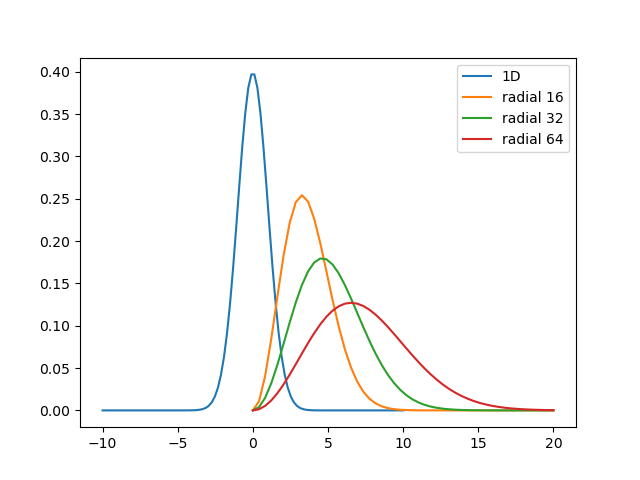

 initialize empty path and and start and end position in origin 
 perform importance sampling t-times 


In [4]:
hugo = randomWalk(16)
print("at the beginning: ", hugo.N, hugo.steps, hugo.currentPos, hugo.end, hugo.start)

print("\nmake the path\n")
hugo.createRandomPath()

print("after path creation:\n",hugo.fullPath.shape,hugo.fullPath.size,"\n")
print(hugo.getRadiusOfGyrationSquared())

figure()
x = np.linspace(-10,10,100)
plot(x,gauss1D(x,1), label = "1D")
x = np.linspace(0,20,50)
plot(x,rdf(x,16), label="radial 16")
plot(x,rdf(x,32), label="radial 32")
plot(x,rdf(x,64), label="radial 64")
legend(loc="best")
show()

# check the docs
print(hugo.__init__.__doc__)
print(hugo.performMCS.__doc__)

<IPython.core.display.Javascript object>


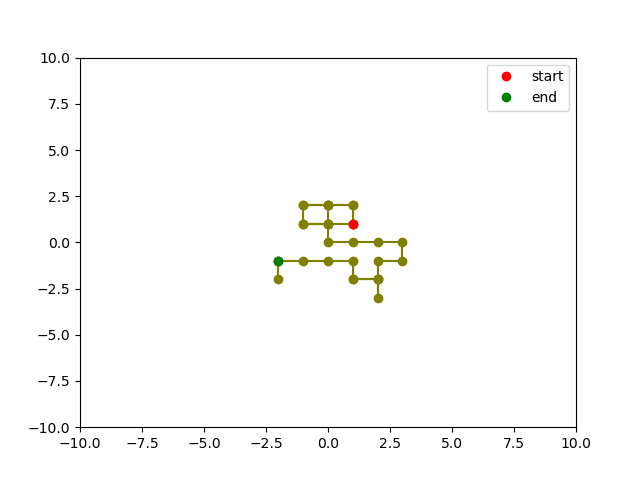

In [5]:
# make some test output
hugo = randomWalk(32)
hugo.createRandomPath()
hugo.showMovie(10)

### Simple sampling

In [8]:
# run simple sampling simulations for end monomer distributions ( N=512, n_iter = 400-1000)
start=time.process_time()
n_iter = 100000
N = 512
# random walk of length N 
walker = randomWalk(N)
# time series of the squared end to end distance
endPositionsX = []
# time series of the squared radius of gyration 
endPositionsR = []
# time series of the x coordinate of the final position 
endToEndPosSq = []
# time series of the end to end distance (norm=root(sum of squared positions))
radiusGyratSq = []

for i in range(n_iter):
    # create random path 
    walker.createRandomPath()
    # make a measurement
    endToEndPosSq.append( walker.getEndToEndDistance()**2 )
    radiusGyratSq.append( walker.getRadiusOfGyrationSquared() )
    endPositionsX.append( walker.getEndToEndDistanceVector()[0] )
    endPositionsR.append( walker.getEndToEndDistance() )
    
print("Simulation time {0:.2f}s ".format( time.process_time()-start ))

Simulation time 1946.00s 


end to end: R^2 = 511.88, R = 22.62
gyration r: R^2 = 85.13, R = 9.23


<IPython.core.display.Javascript object>


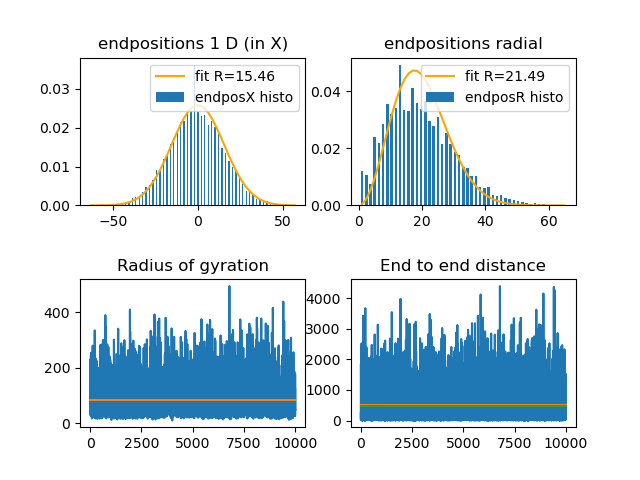

2 * Ree1D^2 == Ree^2 ?:
2 * 15.46^2 = 478.28 == 511.88


In [7]:
# calculate averages
Rg2 = sum(radiusGyratSq)/len(radiusGyratSq)
Re2 = sum(endToEndPosSq)/len(endToEndPosSq)
print("end to end: R^2 = {0:.2f}, R = {1:.2f}".format(Re2,np.sqrt(Re2)))
print("gyration r: R^2 = {0:.2f}, R = {1:.2f}".format(Rg2,np.sqrt(Rg2)))
# make histograms
endPosXHisto, endPosXBins = np.histogram(endPositionsX, bins="auto", density = True)
endPosRHisto, endPosRBins = np.histogram(endPositionsR, bins="auto", density = True)
# make plots 
figure()

subplot(221)
x = endPosXBins[0:-1]
y = endPosXHisto
bar(x,y, label="endposX histo")
fit_params, covar = curve_fit( gauss1D, x, y, p0=(Re2/2) )
plot(x,gauss1D(x, *fit_params), label="fit R={0:.2f}".format(np.sqrt(fit_params[0])), c = "orange")
#plot(x,gaussian1D(x, 529.30/2), label="fit R={0:.2f}".format(np.sqrt(fit_params[0])), c = "green")
# hist(endPositionsX, bins="auto", label="plt.hist", rwidth=0.5)
# store squared 1D end-to-end dist
fitRee2 = fit_params[0]
legend()
title("endpositions 1 D (in X)")

subplot(222)
x = endPosRBins[0:-1]
y = endPosRHisto
bar(x,y, label="endposR histo")
fit_params, covar = curve_fit(rdf, x, y)
plot(x,rdf(x, *fit_params), label="fit R={0:.2f}".format(np.sqrt(fit_params[0])), c = "orange")
# hist(endPositionsR, bins="auto", label="plt.hist", rwidth=0.5)
legend()
title("endpositions radial")

subplot(223)
plot(np.linspace(0,len(radiusGyratSq),len(radiusGyratSq)),radiusGyratSq)
plot([0,len(radiusGyratSq)],[Rg2,Rg2])
title("Radius of gyration")

subplot(224)
plot(np.linspace(0,len(endToEndPosSq),len(endToEndPosSq)),endToEndPosSq)
plot([0,len(endToEndPosSq)],[Re2,Re2])
plot([0,len(endToEndPosSq)],[fit_params[0],fit_params[0]])
title("End to end distance")

subplots_adjust(hspace=.5)

#show()

print( "2 * Ree1D^2 == Ree^2 ?:\n2 * {0:.2f}^2 = {1:.2f} == {2:.2f}".format(np.sqrt(fitRee2), 2*fitRee2, Re2 ))



In [ ]:
# wrap simulations for R(N) calculations
''' make a function from the above simulation code '''
def performSimpleSample(N,n_iter):
    walker = randomWalker(N)
    endToEndPosSq = []
    radiusGyratSq = []

    for i in range(n_iter):
        # create a sample
        walker.createRandomPath()
    
        # make a measurement
        endToEndPosSq.append( walker.getEndToEndDistance()**2 )
        radiusGyratSq.append( walker.getRadiusOfGyrationSquared() )
    
    Rg2 = sum(radiusGyratSq)/len(radiusGyratSq)
    Re2 = sum(endToEndPosSq)/len(endToEndPosSq)
    
    return Re2, Rg2

''' define power law '''
def powerLaw(x,a,b):
    return a*x**b

In [8]:
# run simple sampling simulations for size scaling
walkLengths = [16,32,64,128,256,512,1024,2048]
n_iter = 1000
Re = []
Rg = []

for myN in walkLengths:
    re2, rg2 = performSimpleSample(myN,n_iter)
    print(re2,rg2)
    Re.append(re2)
    Rg.append(rg2)    

In [9]:
# visualize simple sampling R(N) results
figure()
subplot(211)
plot(walkLengths,Re, label="simulation")
fit_params, covar = curve_fit(powerLaw, walkLengths, Re)
plot(walkLengths,powerLaw(walkLengths,*fit_params), "--", label="ax^b: a={0:.3f}, b={1:.3f}".format(*fit_params))
title("End to end distance")
xlabel("N")
ylabel(r"$R_{ee}^2$")
legend()
b1 = np.copy(fit_params[0])

subplot(212)
plot(walkLengths,Rg, label="simulation")
fit_params, covar = curve_fit(powerLaw, walkLengths, Rg)
plot(walkLengths,powerLaw(walkLengths,*fit_params), "--", label="ax^b: a={0:.3f}, b={1:.3f}".format(*fit_params))
title("Radius of gyration")
xlabel("N")
ylabel(r"$R_{g}^2$")
legend()

subplots_adjust(hspace=.5)

print( "b1/b2 = {0:.2} ( = 6 ?)".format(b1/fit_params[0]) )

### Importance Sampling

In [ ]:
# implementation of perform mcs in class random walker
+-o-+

+
| 
o-+

o--++  ->  ++--o


# choose a random position
# check if start or end -> move only end with step that does not change bond lenght
# if inner segment: check if straigth line -> no move possible / else move along diffs for a kink or a swith
# if time is left: sanity check for bond lengths and path length

autocorrelation function:

$c(\Delta t) = \frac{\langle R_e(t_0) * Re(t_0 + \Delta t)\rangle}{\langle Re^2 \rangle}$

In [97]:
def calcMSD(x):
    '''calculates the mean-squared-displacement(MCS) 
        MSD(Dt)=< (R(t+Dt)-R(t))^2 >
    '''
    MSD=np.zeros(x.shape[0])
    counter=np.zeros(x.shape[0])
    MSD[0]=0
    for Dt in range(1,x.shape[0]-1): 
        #msd for a fixed time 
        msd=np.zeros(x.shape[1])
        for t in range(0,x.shape[0]-Dt): 
            # calculates the msd per monomer 
            # (R_i(t+Dt)-R_i(t))^2
            msd+=np.linalg.norm(x[t+Dt]-x[t],ord=2)**2
        MSD[Dt]=msd.sum(axis=0)/(float (msd.shape[0]*(x.shape[0]-Dt)))
    return MSD
def sampleReDt(n_iter,N):
    # setup walker
    impWalker = randomWalk(N)
    impWalker.createRandomPath()
    
    # initial result container
    firstRe = impWalker.getEndToEndDistanceVector()
    ReDt = [np.dot(firstRe,firstRe)]
    Re2 = [np.square(impWalker.getEndToEndDistance())]
    Positions=np.zeros((n_iter,N,2)) 
    # run the simulations
    for i in range(n_iter-1):
        impWalker.performMCS(1)
        Re2.append(np.square(impWalker.getEndToEndDistance()))
        ReDt.append(np.dot(firstRe,impWalker.getEndToEndDistanceVector()))
        Positions[i]=impWalker.fullPath
    
    # average the Re2
    reMean = sum(Re2)/len(Re2)
    # return the results
    return reMean, np.array(ReDt), calcMSD(Positions)

In [98]:
# run the ReDt sampling many times
s_time = 1000
n_sample = 10
N = 64

meanReDt = np.zeros(s_time)
reMean = 0.0

for n in range(n_sample):
    reC, redtC, MSD = sampleReDt(s_time, N)
    print(reC, redtC.size)
    reMean += reC
    meanReDt += redtC

reMean /= n_sample
meanReDt /= n_sample
print(reMean, meanReDt[:4])

56.344 1000
24.008 1000
101.412 1000
104.876 1000
33.84 1000
28.94 1000
27.396 1000
32.704 1000
42.544 1000
31.264 1000
48.332800000000006 [63.4 61.6 57.3 56.8]


<IPython.core.display.Javascript object>


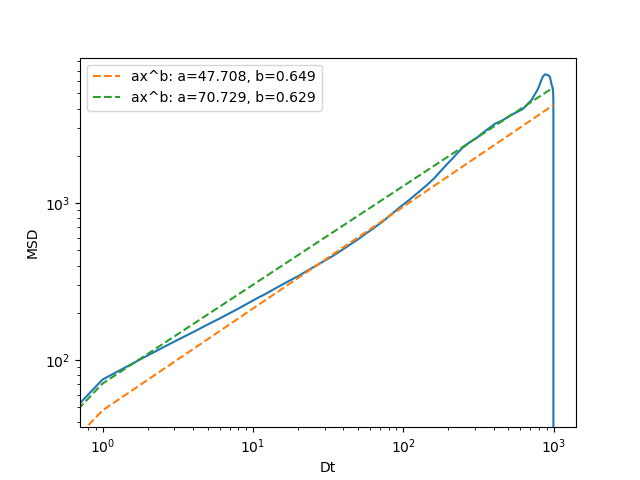

In [87]:
figure ()
xscale('log')
yscale('log')
''' define power law '''
def powerLaw(x,a,b):
    return a*x**b
t=arange(0,s_time)
#ylim(0.1,10)
plot(t,MSD)
xlabel('Dt')
ylabel('MSD')
fit_params, covar = curve_fit(powerLaw, t[2:100], MSD[2:100])
plot(t,powerLaw(t,*fit_params), "--", label="ax^b: a={0:.3f}, b={1:.3f}".format(*fit_params))
fit_params, covar = curve_fit(powerLaw, t[200:700], MSD[200:700])
plot(t,powerLaw(t,*fit_params), "--", label="ax^b: a={0:.3f}, b={1:.3f}".format(*fit_params))
legend(loc='best')


<IPython.core.display.Javascript object>


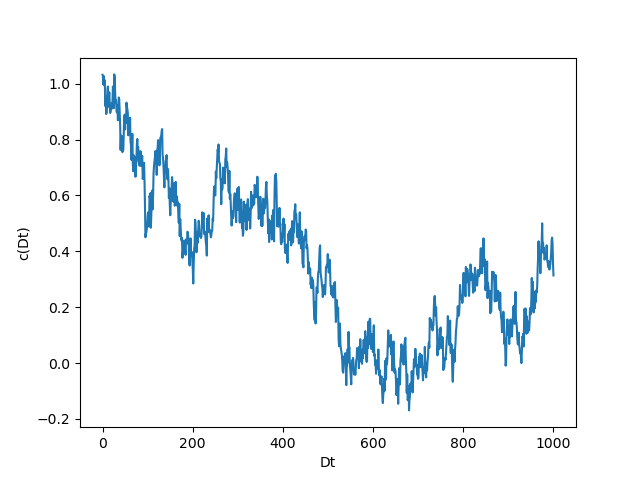

In [86]:
figure()
ylabel('c(Dt)')
xlabel('Dt')
plot(np.linspace(0,s_time,s_time),meanReDt/reMean)
show()
